In [ ]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import pandas as pd
import numpy as np
from functools import reduce
import contextily as ctx
import datetime as dt
import math
import plotly.express as px
from scipy.stats import spearmanr

#Importing spatial libraries
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot

/home/jovyan/venv/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
#Loading all city datasets

#Loading rental prioritisation data for rental assistance index and minortiy percentage population visualisations
rent_data = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/rent prioritisation/housing_index_state_adj.geojson')
#Converting GEOID from string to float for merging
rent_data['GEOID'] = rent_data['GEOID'].astype(float)

#Reading the redlining data made available by the Mapping Inequality Project
redline_data = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/redlining_all/shapefile/holc_ad_data.shp')

#Changing column names 
rent_data = rent_data.rename(columns={'total_index_quantile':'rental_assistance_index', 'perc_person_of_color':'percentage_minority'})
redline_data = redline_data.rename(columns={'ordinal_value':'redlining_index'})

#Boston Data
boston_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/boston/boston_redlined_numerical_values.geojson')
boston_redline = boston_redline.rename(columns={'ordinal_value':'redlining_index'})
boston_rent_data = rent_data.merge(boston_redline[['GEOID','reweighted_redline_index','redlining_index']],how='inner',on='GEOID')

In [ ]:
redline_data[redline_data['city']=='Boston'].shape

(39, 8)

In [ ]:
#Function for visualising rental index and minority populations for each city
def minority_rental_map(y1,y2,x1,x2,city):
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 15))

    ax1.set_title('Minority Distribution'+city, fontsize=18)
    minorities_data.plot(ax=ax1, column='percentage_minority', legend = True, linewidth=.6, edgecolor='0.2',cmap='coolwarm')

    ax2.set_title('Rental Prioritisation in'+city, fontsize=18)
    rent_data.plot(ax= ax2, column = 'rental_assistance_index',cmap='coolwarm',linewidth=.6, edgecolor='0.2',legend=True)

    ax1.set_ylim(y1, y2)
    ax1.set_xlim(x1,x2)

    ax2.set_ylim(y1,y2)
    ax2.set_xlim(x1,x2)

In [ ]:
boston_redline.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'reweighted_redline_index', 'redlining_index', 'geometry'],
      dtype='object')

In [ ]:
minorities_data.head()

,GEOID,county_name,state_name,percentage_minority,geometry
31071,2.502506e+10,Suffolk County,Massachusetts,0.086220,"MULTIPOLYGON (((-71.04776 42.33681, -71.04556 ..."
31072,2.502506e+10,Suffolk County,Massachusetts,0.822609,"MULTIPOLYGON (((-71.05693 42.32855, -71.05262 ..."
31073,2.502507e+10,Suffolk County,Massachusetts,0.474770,"MULTIPOLYGON (((-71.06423 42.35339, -71.06331 ..."
31074,2.502507e+10,Suffolk County,Massachusetts,0.701835,"MULTIPOLYGON (((-71.06850 42.34760, -71.06819 ..."
31075,2.502507e+10,Suffolk County,Massachusetts,0.521678,"MULTIPOLYGON (((-71.07694 42.33653, -71.07500 ..."


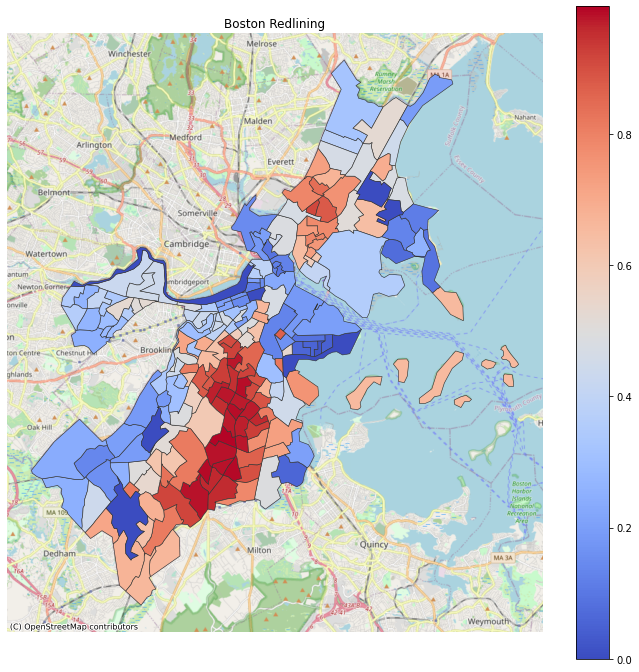

In [ ]:
#Mapping SES SVI Tracts Across Boston
ax = minorities_data.to_crs('EPSG:3857').plot(column='percentage_minority', legend = True, linewidth=.6, edgecolor='0.2', cmap='coolwarm', figsize=(12,12))
ctx.add_basemap(ax, zoom=12, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Boston Redlining')
ax.set_axis_off()

In [ ]:
boston_redline.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'reweighted_redline_index', 'redlining_index', 'geometry'],
      dtype='object')

In [ ]:
#Function for visualising rental and redlining maps for each city
def rental_redline_map(y1,y2,x1,x2,city,state_redline):

    f, ax = plt.subplots(figsize=(15, 15))

    redline_data.to_crs('EPSG:3857').plot(ax = ax, column = 'holc_grade',categorical=True,cmap='coolwarm',linewidth=.6, edgecolor='0.3',legend=True, legend_kwds={'bbox_to_anchor':(.5, 1.05),'fontsize':12,'frameon':False})
    ctx.add_basemap(ax, zoom=12, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_ylim(y1,y2)
    ax.set_xlim(x1,x2)

    ax.set_title('Boston Redlining')
    ax.set_axis_off()

In [ ]:
rental_redline_map(42.261061, 42.400148,-71.128787,-70.983219,'Boston',boston_redline)

SyntaxError: invalid syntax (<ipython-input-22-338ceb4a101f>, line 1)

KernelInterrupted: Execution interrupted by the Jupyter kernel.

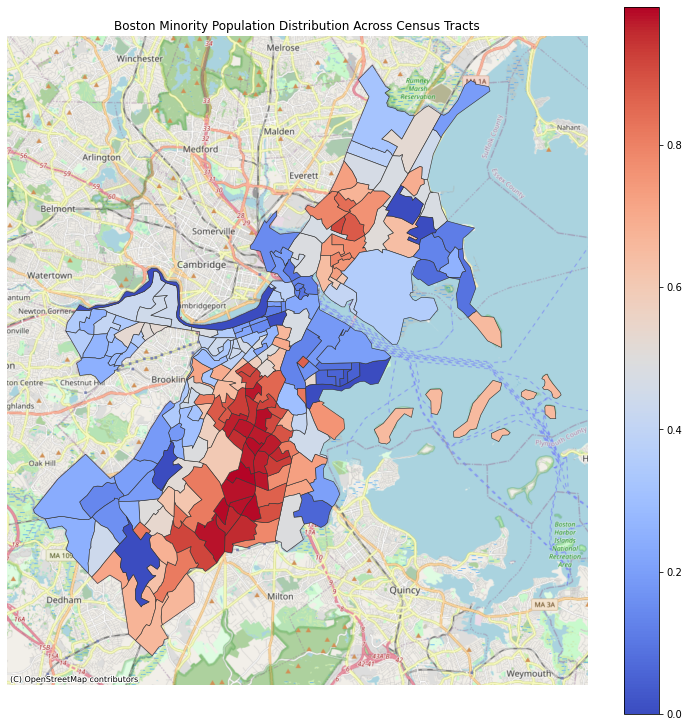

In [ ]:
#Subsetting rental prioritisation data for only minority population details
minorities_data = rent_data[['GEOID','county_name','state_name','percentage_minority','geometry']]

minorities_data = minorities_data[(minorities_data['county_name']=='Suffolk County') & (minorities_data['state_name']=='Massachusetts')]

ax = minorities_data.to_crs('EPSG:3857').plot(column='percentage_minority',figsize=(13,13), legend = True, linewidth=.6, edgecolor='0.2',cmap='coolwarm')
ctx.add_basemap(ax, zoom=12, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Boston Minority Population Distribution Across Census Tracts')
ax.set_axis_off()

In [ ]:
rent_data.columns

Index(['GEOID', 'state_name', 'county_name', 'state_fips', 'county_fips',
       'perc_cost_burdened_under_35k', 'perc_overcrowding_renter_1.50_or_more',
       'perc_unemployed_laborforce', 'perc_renters', 'perc_poverty_12mnth',
       'perc_no_hinsure', 'percentage_minority', 'perc_public_assistance',
       'perc_foreign_born', 'perc_30hamfi', 'perc_low_income_jobs_lost',
       'housing_index', 'covid_index', 'equity_index', 'total_index',
       'housing_index_quantile', 'covid_index_quantile',
       'equity_index_quantile', 'rental_assistance_index',
       'z_score_perc_cost_burdened_under_35k',
       'z_score_perc_overcrowding_renter_1.50_or_more',
       'z_score_perc_unemployed_laborforce', 'z_score_perc_renters',
       'z_score_perc_poverty_12mnth', 'z_score_perc_no_hinsure',
       'z_score_perc_person_of_color', 'z_score_perc_public_assistance',
       'z_score_perc_foreign_born', 'z_score_perc_30hamfi',
       'z_score_perc_low_income_jobs_lost',
       'z_score_perc_c

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c9a4f701-31a5-4164-b3f3-c09cddf1309e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>